# Gradient Descent

In this workshop we will develop the basic algorithms in the context of two common problems: 
### 1. Linear regression 
### 2. Logistic regression for binary classification. 

## Linear regression

To begin, we need some data. We can use the `make_regression()` function from Python machine learning library *scikit-learn* (http://scikit-learn.org) to create a synthetic dataset. For illustrative purposes, we choose a single input variable, but everything we cover applies to higher dimensional data also.

In [1]:
from sklearn.datasets import make_regression 

data, label = make_regression(n_samples=100, 
                       n_features=1,
                       n_informative=1,
                       noise=20, # To add disparity
                       random_state=0)

As always, we start by visualising our data.

In [2]:
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')

Now let's create a scatter plot from our data.

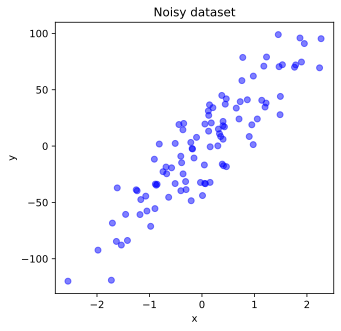

In [3]:
# create figure
fig = plt.figure(figsize=(5, 5))
# add subplot (rows, cols, number)
ax = fig.add_subplot(1, 1, 1, xlabel='x', ylabel='y')
# plot data on new axis
ax.scatter(data, label, color='blue', alpha=0.5)
ax.set_title('Noisy dataset')
# display plot
plt.show()

Given our data, a feature matrix of $N$ samples in $d$ dimensions $\mathbf{X} \in \mathbb{R}^{nxd}$ and output vector $y \in \mathbb{R}^{N}$, our objective will be to learn a linear function,

$$\hat{y}_i = \beta_0 + \beta_1x_i$$ with $\hat{y}$ is the label to the input data $x$, such that the sum of square errors $\sum_i(y_i - \hat{y}_i)^2$ is minimised. Each parameter corresponds to a column (feature) of $\mathbf{X}$ and to learn an intercept term also, we append a column of 1s to $\mathbf{X}$. This is called the *bias trick*:

$$
\underbrace{
\begin{bmatrix}
    x_{11} & x_{12} & \dots & x_{1d} \\
    x_{21} & x_{22} & \dots & x_{2d} \\
    \vdots & \vdots & \ddots & \vdots \\
    x_{n1} & x_{n2} & \dots & x_{nd}
\end{bmatrix}}_{\mathbf{X}} \to
\underbrace{
\begin{bmatrix}
    1 & x_{11} & x_{12} & \dots & x_{1d} \\
    1 & x_{21} & x_{22} & \dots & x_{2d} \\
    \vdots & \vdots & \vdots & \ddots & \vdots \\
    1 & x_{n1} & x_{n2} & \dots & x_{nd}
\end{bmatrix}}_{\text{$\mathbf{X}$ with bias variable}}
$$

In [4]:
import numpy as np
# augment data with bias trick
N = data.shape[0]
data_concatenated = np.concatenate([np.ones((N, 1)), data], axis=1)
# print the first few values
print(data_concatenated[:10])

[[ 1.         -0.35955316]
 [ 1.          0.97663904]
 [ 1.          0.40234164]
 [ 1.         -0.81314628]
 [ 1.         -0.88778575]
 [ 1.          0.44386323]
 [ 1.         -0.97727788]
 [ 1.          0.42833187]
 [ 1.          0.20827498]
 [ 1.         -0.31155253]]


### Ordinary least squares

In this basic setting there is an analytic solution to our minimisation problem. Recall that least squares linear regression uses a quadratic loss function:

$$\mathcal{L}(\boldsymbol\beta) = \frac{1}{2N}\sum_{i=1}^N(y_i - \boldsymbol\beta^T\mathbf{x}_i)^2 = \frac{1}{2N}(\mathbf{y} - \mathbf{X}\boldsymbol\beta)^T(\mathbf{y} - \mathbf{X}\boldsymbol\beta)$$

With some vector calculus, we can differentiate and obtain the *normal equation*,

$$\boldsymbol\beta^* = (\mathbf{X}^T\mathbf{X})^{-1}\mathbf{X}^T\mathbf{y}$$

where $\boldsymbol\beta^*$ are the parameters minimising the loss.

The optimal parameter vector $\boldsymbol\beta^*$ obtained by solving the normal equation for `x_bt` and `y`:

In [5]:
from numpy.linalg import inv
beta = np.dot(np.dot(inv(np.dot(data_concatenated.T,data_concatenated)),data_concatenated.T),label)
print(beta)

[-1.62836365 42.85335573]


Prediction $\hat{\mathbf{y}} = \mathbf{X}{\boldsymbol\beta^*}$ on training data using the learned parameters:

In [6]:
label_pred = np.dot(data_concatenated,beta)

Now let's visualise our regression line:

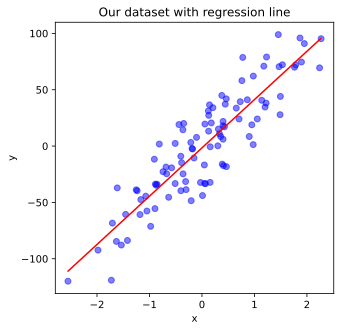

In [7]:
# create figure
fig = plt.figure(figsize=(5, 5))
# add subplot (rows, cols, number)
ax = fig.add_subplot(1, 1, 1, xlabel='x', ylabel='y')
# plot data on new axis
ax.scatter(data, label, color='blue', alpha=0.5)
# plot regression line
ax.plot(data, label_pred, color='red')
ax.set_title('Our dataset with regression line')
# display plot
plt.show()

Implement the quadratic loss (MSE) to quantify the error

In [8]:
def mean_square_error(data, label, beta):
    label_pred = np.dot(data_concatenated,beta) 
    return np.square(label - label_pred).mean(axis=0)/2.0

mse = mean_square_error(data_concatenated, label, beta)
print('MSE: %.02f RMSE: %.02f' % (mse, np.sqrt(mse)))

MSE: 228.34 RMSE: 15.11


Note the closeness of the RMSE and the noise parameter we used to create the dataset.

### Gradient Descent

A closed-form solution like least squares will not always be available to us, however, and we instead consider numerical optimisation techniques. *Gradient descent* finds a convex minimum by making progressive steps in the direction opposite the gradient. That is,

$$\boldsymbol\beta_{k+1} = \boldsymbol\beta_{k} - \alpha\nabla_{\boldsymbol\beta}\mathcal{L}$$

for each iteration $k$ and some step size $\alpha$, known as the *learning rate*.

#### Batch gradient descent

To perform a gradient descent, we need to be able to query the gradient at each iteration. Therefore, we implement a function to evaluate the gradient. The gradient of a linear regression is,

$$\nabla_{\boldsymbol\beta}\mathcal{L} = \frac{1}{N}\mathbf{X}^T(\mathbf{X}\boldsymbol\beta - y)$$

which is an $\mathcal{O}(ND)$ computation.

In [9]:
def evaluate_gradient(data, label, beta):
    return (1.0/data.shape[0])*np.dot(data.T,(np.dot(data,beta) - label))

To validate the function, the gradient at our least squares solution should be zero

In [10]:
from numpy.linalg import norm
print(norm(evaluate_gradient(data_concatenated, label, beta)))

5.877030361857661e-15


Now we implement a batch gradient descent algorithm.

In [11]:
def batch_gradient_descent(data, label, lr=1e-1, max_iters=100, tol=1e-2):
    # randomly initialise beta
    N, D = data.shape
    beta = np.random.rand(D)
    # initialise histories
    losses = [mean_square_error(data, label, beta)]
    betas = [beta.copy()]

    for i in range(max_iters):
        grad = evaluate_gradient(data, label, beta)
        beta -= lr*grad
        loss = mean_square_error(data, label, beta)
        losses.append(loss)
        betas.append(beta.copy())

        if np.sqrt(grad.dot(grad)) < tol: break

    return np.array(betas), np.array(losses)

Now let's run it on our data. 

In [12]:
# Run batch gradient descent
betas, losses = batch_gradient_descent(data_concatenated, label)
print(betas[-1])

[-1.62410867 42.84594641]


Let's visualise our gradient descent:

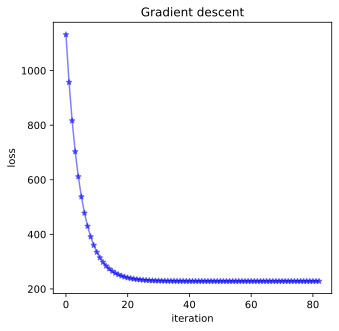

In [13]:
# create figure
fig = plt.figure(figsize=(5, 5))
# add subplot (rows, cols, number)
ax = fig.add_subplot(1, 1, 1, xlabel='iteration', ylabel='loss')
# plot data on new axis
ax.plot(losses, color='blue', marker='*', alpha=0.5)
ax.set_title('Gradient descent')
# display plot
plt.show()

Finally, let's make a nice 3-dimensional plot of our gradient descent:

/home/fouad/miniconda3/envs/DL/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning: The following kwargs were not used by contour: 'color'


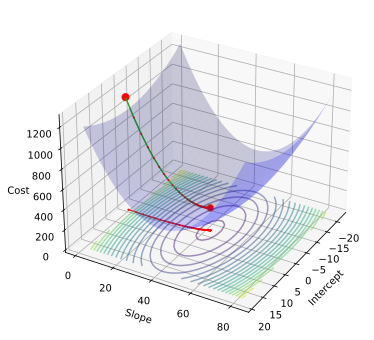

In [14]:
from mpl_toolkits.mplot3d import Axes3D

# create meshgrid
ms = np.linspace(beta[0] - 20 , beta[0] + 20, 20)
bs = np.linspace(beta[1] - 40 , beta[1] + 40, 40)
M, B = np.meshgrid(ms, bs)
zs = np.array([mean_square_error(data_concatenated, label, theta)
               for theta in zip(np.ravel(M), np.ravel(B))])
Z = zs.reshape(M.shape)

# create 3D axis object
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1, projection='3d', xlabel='Intercept',
                     ylabel='Slope', zlabel='Cost')

# plot mse loss hypersurface and contours
ax.plot_surface(M, B, Z, rstride=1, cstride=1, color='b', alpha=0.2)
ax.contour(M, B, Z, 20, color='b', alpha=0.5, offset=0, stride=30)

# plot start and end points
ax.plot([betas[0][0]], [betas[0][1]], [losses[0]] , markerfacecolor='r', markeredgecolor='r', marker='o', markersize=7);
ax.plot([betas[-1][0]], [betas[-1][1]], [losses[-1]] , markerfacecolor='r', marker='o', markersize=7);

# plot gradient descent curves
ax.plot(betas[:, 0], betas[:, 1], losses, markeredgecolor='r', marker='.', markersize=2);
ax.plot(betas[:, 0], betas[:, 1], 0, markeredgecolor='r', marker='.', markersize=2);

# set viewpoint
ax.view_init(elev=30, azim=30)

plt.show()

#### Strong Convexity

Strong convexity implies a quadractic lower bound on a function. A multivariate function $\mathcal{L}(\boldsymbol\beta)$ is $\mu$-strongly convex iff $\nabla_{\boldsymbol\beta\boldsymbol\beta}\mathcal{L} \succeq \mu$ for $\mu > 0$, that is, its Hessian matrix is positive definite. The gradient descent of a strongly convex function is guaranteed convergence with,

$$\mathcal{L}(\boldsymbol\beta_t) - \mathcal{L}(\boldsymbol\beta_*) \leq (1 - \mu/L)^{2t}[\mathcal{L}(\boldsymbol\beta_t) - \mathcal{L}(\boldsymbol\beta_*)]$$

where $\boldsymbol\beta_t$ is the parameter vector at iteration $t$, $\boldsymbol\beta_*$ are the optimal parameters, and $\mu$ and $L$, used as the learning rate, are respectively the smallest and largest eigenvalues of the $\mathcal{L}$. That is, the *regret* converges exponentially to zero by the iteration.

A matrix is positive definite iff its eigenvalues are strictly positive. For our quadratic loss function, the Hessian matrix, also known as the Gram matrix, is given by $$\nabla_{\beta\beta}\mathcal{L} = \frac{1}{N}\mathbf{X}^T\mathbf{X}$$

In [15]:
from numpy.linalg import eigvals
eigens = eigvals(np.dot(data_concatenated.T,data_concatenated))
print(eigens)

[ 94.91120093 107.02916086]


The eigenvalues of the Gram matrix verify the strong convexity of our regression's quadratic loss:

Calculate a range of gradient descent losses including $1/L$, where $L$ is the largest eigenvalue.

In [16]:
lr = [1.0/eigens[1],1.0/eigens[0],1.0/eigens[1]] # Three learning rates including the theoretical 1/L
# Now we run gradient descent for each
_, losses1 = batch_gradient_descent(data_concatenated, label, lr=lr[0])
_, losses2 = batch_gradient_descent(data_concatenated, label, lr=lr[1])
_, losses3 = batch_gradient_descent(data_concatenated, label, lr=lr[2])

Now we will visualise the losses. This time we use a log scale so as to observe the exponential improvement towards the least squares solution. We subtract the optimal mse computed above so that the losses converge to 0:

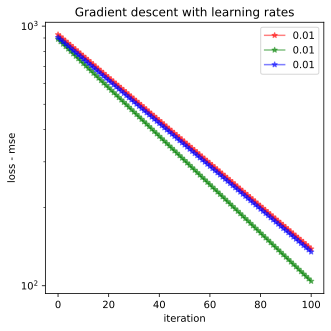

In [17]:
# create figure
fig = plt.figure(figsize=(5, 5))
# add subplot (rows, cols, number)
ax = fig.add_subplot(1, 1, 1, xlabel='iteration', ylabel='loss - mse')
# plot data on new axis
ax.plot(losses1 - mse, color='red', marker='*', alpha=0.5, label='%.02f' % lr[0])
ax.plot(losses2 - mse, color='green', marker='*', alpha=0.5, label='%.02f' % lr[1])
ax.plot(losses3 - mse, color='blue', marker='*', alpha=0.5, label='%.02f' % lr[2])
ax.set_title('Gradient descent with learning rates')
ax.set_yscale('log')
# add legend
plt.legend()
# display plot
plt.show()

Try different learning rates (e.g. higher and lower) and observe the effects.

## Problem #2 - binary classification

For this problem, we will use an external dataset. Download the following: http://www.di.ens.fr/%7Efbach/orsay2017/data_orsay_2017.mat. Although a MATLAB file, we can use a handy scipy routine to read the data:

In [18]:
from scipy import io
data = io.loadmat('data_orsay_2017.mat')

We extract the relevant data from this dictionary object and print its dimensions:

In [19]:
X_train, y_train = data['Xtrain'], data['ytrain']
X_test, y_test = data['Xtest'], data['ytest']

print('X_train shape: %s' % str(X_train.shape))
print('y_train shape: %s' % str(y_train.shape))
print('X_test shape: %s' % str(X_test.shape))
print('y_test shape: %s' % str(y_test.shape))

X_train shape: (10000, 100)
y_train shape: (10000, 1)
X_test shape: (100000, 100)
y_test shape: (100000, 1)


Once again we perform the bias trick:

In [20]:
X_train_concatenated = np.concatenate([np.ones((X_train.shape[0], 1)), X_train], axis=1)
X_test_concatenated = np.concatenate([np.ones((X_test.shape[0], 1)), X_test], axis=1)

In a logistic regression we encode the positive and negative classes as $y \in \{-1, 1\}$. Then, $p(y = 1|\mathbf{x}^T\boldsymbol\beta) = \sigma(\mathbf{x}^T\boldsymbol\beta)$ and $p(y = -1|\mathbf{x}^T\boldsymbol\beta) = 1 - \sigma(\mathbf{x}^T\boldsymbol\beta) = \sigma(-\mathbf{x}^T\boldsymbol\beta)$, where $\sigma(x) = 1/(1 + \exp(-x))$ is the *sigmoid* or *logistic* function. To learn the model, we minimise the mean cross-entropy between the predicted distribution and the ground truth, which we can take to be *one-hot*, putting all probability on the correct class. This simplifies the loss function to,

$$\frac{1}{N}\sum_{i=1}^N\log(1 + \exp(-y_i\mathbf{x}^T\boldsymbol\beta))$$

In [21]:
from numpy import log, exp

def log_loss(X, y, beta):
    x = y*np.dot(X,beta)
    return log(1+exp(-x)).mean(axis=0)

The logistic loss gradient:

$$\nabla_\beta\mathcal{L} = \sum_{i=1}^N \frac{-\mathbf{x}_i\cdot y_i}{1 + \exp(y_i\mathbf{x}_i^T\beta)}$$

In [22]:
def evaluate_gradient(X, y, beta):
    A = -X*y
    B = 1 + exp(y*np.dot(X,beta))
    return np.sum(A/B,axis= 0)


### Stochastic gradient descent

In larger applications, computing the full gradient can be expensive. Moreover, a sample of size $M < N$ from a large dataset at each iteration is often sufficient to make an accurate descent step. *Minibatch gradient descent* uses a size $M$ subsample of the data at each iteration. In the extreme case that $M = 1$ we have what is known as *stochastic gradient descent*. The gradient computation therefore goes from a complexity of $\mathcal{O}(ND)$ to $\mathcal{O}(MD)$. In the training of deep neural networks, minibatch gradient descent (and its variants) is overwhelmingly the most popular approach, where a stochastic element additionally may help to avoid local minima of their non-convex loss functions.

Operationally, the only thing that changes is the amount of data, we feed our gradient function, what we will call the *batch*. The most obvious strategy for selecting a batch is to cycle through the (pre-shuffled) data and slice the next $M$ values. Thus, at iteration $i$, we calculate the gradient as,

$$\nabla_{\beta}\mathcal{L}_{\text{batch}} = \frac{1}{M}\mathbf{X}_{i:i+M}^T(\mathbf{X}_{i:i+M}\beta - y_{i:i+M})$$

A full cycle of the training data is known as an *epoch*.

A cycling strategy for `minibatch_gradient_descent` with a given `batch_size`:

In [23]:
def minibatch_gradient_descent(X, y, batch_size=10, lr=1e-1, max_iters=1000, tol=1e-5):
    # randomly initialise beta
    N, D = X.shape
    beta = np.random.rand(D, 1)
    # initialise history variables
    losses = [log_loss(X, y, beta)]
    betas = [beta]

    for i in range(max_iters):
        batchX = X[i*batch_size:(i+1)*batch_size]
        batchY = y[i*batch_size:(i+1)*batch_size]
        grad = evaluate_gradient(batchX, batchY, beta)
        grad = grad[:, np.newaxis]
        beta -= grad*lr
        if i % 10 == 0:
            loss = log_loss(X, y, beta)
            losses.append(loss)
        betas.append(beta.copy())

        if np.sqrt(grad.T.dot(grad)) < tol: break

    return betas, losses

Now we run minibatch gradient descent on our problem:

In [24]:
# Run batch gradient descent
betas, losses = minibatch_gradient_descent(X_train_concatenated, y_train, batch_size=10, lr=1e-0)

The probabilties $\hat{\mathbf{p}} = \sigma(\mathbf{X}{\beta})$ on our test data using the learned parameters.

In [25]:
from scipy.special import expit
beta = betas[-1]
probs = expit(np.dot(X_test_concatenated,beta))

For each test sample $\mathbf{x}_i$ the logistic function returns a probability $p_i \in [0, 1]$. To make a prediction, we threshold the probabilities at 0.5: any probabilty $\geq0.5$ we will say is positive; any $<0.5$ negative. Because we chose to encode our outputs as $y \in {-1, 1}$, we will map our positives and negatives to $1$ and $-1$ respectively.

In [26]:
y_pred = np.zeros((probs.shape))
for i in range(probs.shape[0]):
    if (y_pred[i] >=0.5):
        y_pred[i] = 1
    else:
        y_pred[i] = -1

Now we can check the accuracy of our model:

In [27]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

0.50097

Let's choose different batch sizes. Try $M = 1$ for pure stochastic gradient descent and try a large batch size for comparison:

In [28]:
bs = [1,10,100] # TODO: Create list of different batch sizes including M = 1
_, losses1 = minibatch_gradient_descent(X_train, y_train, batch_size=bs[0])
_, losses2 = minibatch_gradient_descent(X_train, y_train, batch_size=bs[1])
_, losses3 = minibatch_gradient_descent(X_train, y_train, batch_size=bs[2])

Let's visualise our descent curves:

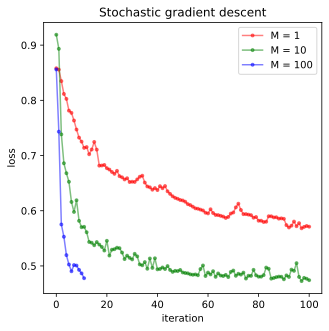

In [29]:
# create figure
fig = plt.figure(figsize=(5, 5))
# add subplot (rows, cols, number)
ax = fig.add_subplot(1, 1, 1, xlabel='iteration', ylabel='loss')
# plot data on new axis
ax.plot(losses1, color='red', marker='.', alpha=0.5, label='M = %s'%bs[0])
ax.plot(losses2, color='green', marker='.', alpha=0.5, label='M = %s'%bs[1])
ax.plot(losses3, color='blue', marker='.', alpha=0.5, label='M = %s'%bs[2])
ax.set_title('Stochastic gradient descent')
# display lengend
plt.legend()
# display plot
plt.show()